### Cats vs Dogs(filtered dataset & without augmentation)
// Code by Om

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img
import os
import kaggle
import zipfile

# Interactive widgets
from ipywidgets import widgets

In [2]:
# !kaggle competitions download -c dogs-vs-cats

In [3]:
# Import the data
base_dir = os.path.join(os.getcwd(), "Data/dogs-vs-cats-complete/train")

#### Data pre-processing

    1. Create tf.data.dataset
    2. Apply various data pipeline functions on the data

In [4]:
# Create tf.data.dataset
training_dataset, validation_dataset = tf.keras.utils.image_dataset_from_directory(base_dir, 
                                                                                   label_mode='binary',
                                                                                   batch_size=128,
                                                                                   image_size=(150, 150),
                                                                                   subset='both',
                                                                                   validation_split=0.1, 
                                                                                   seed=42)

Found 25000 files belonging to 2 classes.
Using 22500 files for training.
Using 2500 files for validation.


2025-06-20 21:46:14.089995: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-06-20 21:46:14.090039: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-06-20 21:46:14.090042: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
I0000 00:00:1750436174.090058 14177487 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1750436174.090081 14177487 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
training_dataset.class_names

['cat', 'dog']

In [6]:
# train_dataset_final = training_dataset.shuffle(1000).cache().prefetch(tf.data.AUTOTUNE)
# validation_dataset_final = validation_dataset.shuffle(1000).cache().prefetch(tf.data.AUTOTUNE)

#### Create and compile a CNN

In [7]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(150,150,3)),
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 148, 148, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18496)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,367,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,391,329 (9.12 MB)

 Trainable params: 2,391,329 (9.12 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

#### Train the CNN model

In [9]:
# EarlyStoppingCallback

class EarlyStopCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs['accuracy']>=0.80 and logs['val_accuracy']>=0.75:
            self.model.stop_training = True
            print("Accuracy has reached 80%% or validation accuracy has reached 75%!")

In [12]:
# Earlystopping method 2
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=3, 
                               restore_best_weights=True, 
                               verbose=1)

In [13]:
history = model.fit(training_dataset, 
                    epochs=15, 
                    validation_data=validation_dataset, 
                    callbacks=[early_stopping])

Epoch 1/15


2025-06-20 21:48:09.930263: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


176/176 ━━━━━━━━━━━━━━━━━━━━ 12s 66ms/step - accuracy: 0.5586 - loss: 0.6829 - val_accuracy: 0.5784 - val_loss: 0.6692
Epoch 2/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 12s 67ms/step - accuracy: 0.6199 - loss: 0.6449 - val_accuracy: 0.6568 - val_loss: 0.6100
Epoch 3/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 12s 67ms/step - accuracy: 0.6630 - loss: 0.6095 - val_accuracy: 0.7008 - val_loss: 0.5770
Epoch 4/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 12s 68ms/step - accuracy: 0.6840 - loss: 0.5823 - val_accuracy: 0.7352 - val_loss: 0.5461
Epoch 5/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - accuracy: 0.7187 - loss: 0.5544 - val_accuracy: 0.7432 - val_loss: 0.5281
Epoch 6/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 12s 68ms/step - accuracy: 0.7306 - loss: 0.5327 - val_accuracy: 0.7272 - val_loss: 0.5282
Epoch 7/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 11s 65ms/step - accuracy: 0.7488 - loss: 0.5138 - val_accuracy: 0.7436 - val_loss: 0.5209
Epoch 8/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 11s 64ms/step - accuracy: 0.7553 - loss: 0.5018 - val_accurac

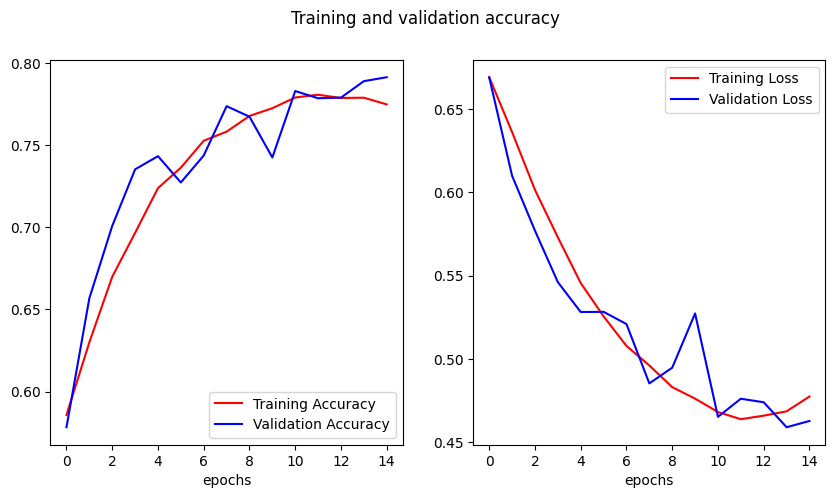

In [14]:
# Get training and validation accuracies
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and validation accuracy')

for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data[0], 'r', label="Training " + label)
    ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

plt.show()